# 1. 데이터 불러오기
## 기본 전처리 및 파생변수 생성


In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'

from tensorflow.keras.applications import VGG16, VGG19, ResNet50
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Lambda, MaxPooling2D, BatchNormalization, Dense, Flatten, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau, TensorBoard
import random
# CSV 파일 경로
matplotlib.rcParams['font.family'] = 'Malgun Gothic' #폰트 설정
matplotlib.rcParams['font.size'] = 8 #글자 크기
matplotlib.rcParams['axes.unicode_minus']= False
tax_info = pd.read_csv('/content/drive/My Drive/open/Tax_info.csv')
customer_info = pd.read_csv('/content/drive/My Drive/open/Customer_info.csv')
discount_info = pd.read_csv('/content/drive/My Drive/open/Discount_info.csv')
marketing_info = pd.read_csv('/content/drive/My Drive/open/Marketing_info.csv')
onlinesales_info = pd.read_csv('/content/drive/My Drive/open/Onlinesales_info.csv')
from datetime import datetime, timedelta

# Calculate the signup year for each customer based on their signup duration
# Assuming the current date is the last known date in the onlinesales_info for simplicity
current_date = pd.to_datetime(onlinesales_info['거래날짜'].max())
customer_info['가입연도'] = current_date - pd.to_timedelta(customer_info['가입기간'], unit='D')
customer_info['가입연도'] = customer_info['가입연도'].dt.year

# Merge online sales info with tax and discount info to calculate total purchase amount
onlinesales_info['거래날짜'] = pd.to_datetime(onlinesales_info['거래날짜'])

# Apply GST from tax_info
onlinesales_info = onlinesales_info.merge(tax_info, left_on='제품카테고리', right_on='제품카테고리', how='left')
onlinesales_info['월'] = onlinesales_info['거래날짜'].dt.strftime('%b')
onlinesales_info_with_discount = pd.merge(onlinesales_info, discount_info, on=['제품카테고리', '월'], how='left')
onlinesales_info_with_discount['할인율'] = onlinesales_info_with_discount['할인율'].fillna(0)
onlinesales_info= onlinesales_info_with_discount.copy()

# Calculate total purchase amount and average cost per item
onlinesales_info['총금액'] = (onlinesales_info['수량'] * onlinesales_info['평균금액'] * (100 - onlinesales_info['할인율']) * (1 + onlinesales_info['GST'])) + onlinesales_info['배송료']

# Calculate total purchase amount and average cost per item for each customer
customer_totals = onlinesales_info.groupby('고객ID').agg(총구매금액=('총금액', 'sum'), 총구매수량=('수량', 'sum')).reset_index()
customer_totals['객단가'] = customer_totals['총구매금액'] / customer_totals['총구매수량']

# Merge totals back with customer info
customer_analysis = customer_info.merge(customer_totals, on='고객ID', how='left')

customer_analysis.head()


Mounted at /content/drive


,고객ID,성별,고객지역,가입기간,가입연도,총구매금액,총구매수량,객단가
0,USER_1358,남,Chicago,12,2019,3471629.961,1133,3064.104114
1,USER_0190,남,California,43,2019,256348.639,175,1464.849366
2,USER_0066,남,Chicago,33,2019,223807.534,155,1443.919574
3,USER_0345,여,California,30,2019,138.188,1,138.188000
4,USER_0683,남,California,49,2019,84124.004,15,5608.266933


# 2. k-means 군집 분석
- 파생 변수 추가
- 변수는 2개가 가장 최적임 확인

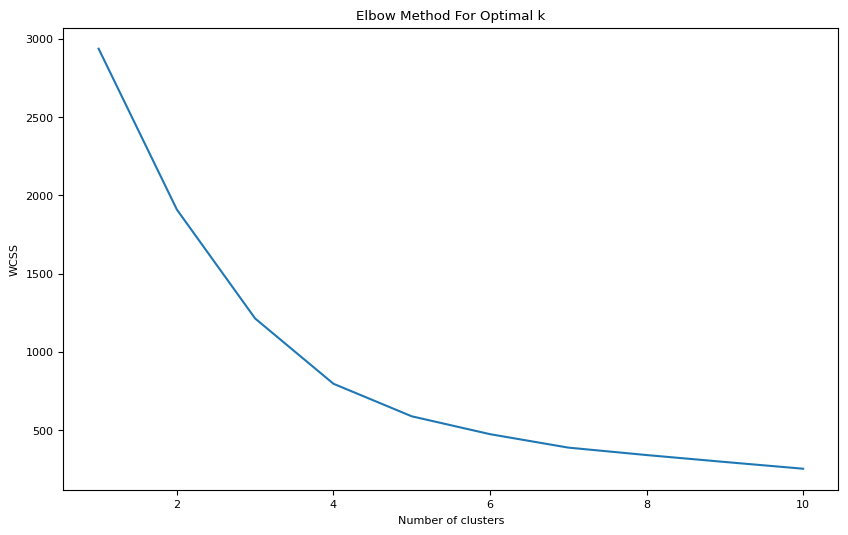

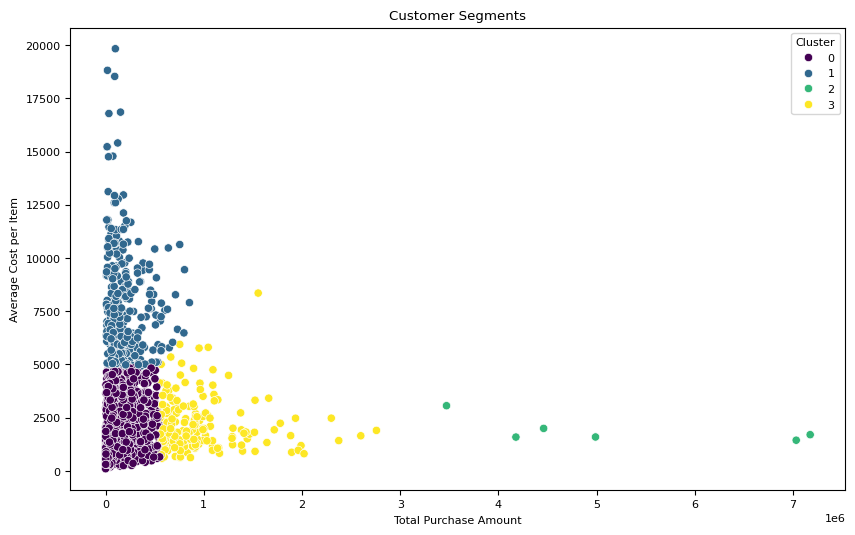

Cluster 0:
Average Total Purchase Amount: 162640.5783492386
Average Cost per Item: 1993.1794259944102
Average Total Purchase count: 113.59796954314722

Cluster 1:
Average Total Purchase Amount: 187432.8364006734
Average Cost per Item: 7887.119218378878
Average Total Purchase count: 26.535353535353536

Cluster 2:
Average Total Purchase Amount: 5217933.751666666
Average Cost per Item: 1899.5903003835392
Average Total Purchase count: 3033.0

Cluster 3:
Average Total Purchase Amount: 939823.107788889
Average Cost per Item: 2224.302477064355
Average Total Purchase count: 555.8888888888889



In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = customer_analysis[['총구매금액', '객단가']].copy()

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
wcss = [] # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
import seaborn as sns
# 최적의 군집 개수를 사용하여 K-means 군집화 실행
optimal_clusters = 4 # Elbow Method로 결정한 최적 군집 개수
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_analysis['군집'] = kmeans.fit_predict(features_scaled)

# 군집 결과 시각화
plt.matplotlib.rcParams['font.family'] = 'Malgun Gothic' #폰트 설정
matplotlib.rcParams['font.size'] = 8 #글자 크기
matplotlib.rcParams['axes.unicode_minus']= False
plt.figure(figsize=(10, 6))
sns.scatterplot(x='총구매금액', y='객단가', hue='군집', data=customer_analysis, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Average Cost per Item')
plt.legend(title='Cluster')
plt.show()

# 군집별 통계 분석
for i in range(optimal_clusters):
    cluster = customer_analysis[customer_analysis['군집'] == i]
    print(f"Cluster {i}:")
    print(f"Average Total Purchase Amount: {cluster['총구매금액'].mean()}")
    print(f"Average Cost per Item: {cluster['객단가'].mean()}")
    print(f"Average Total Purchase count: {cluster['총구매수량'].mean()}")
    print()


## 3개 외 다른 변수를 추가하여도 WCSS 개선 x


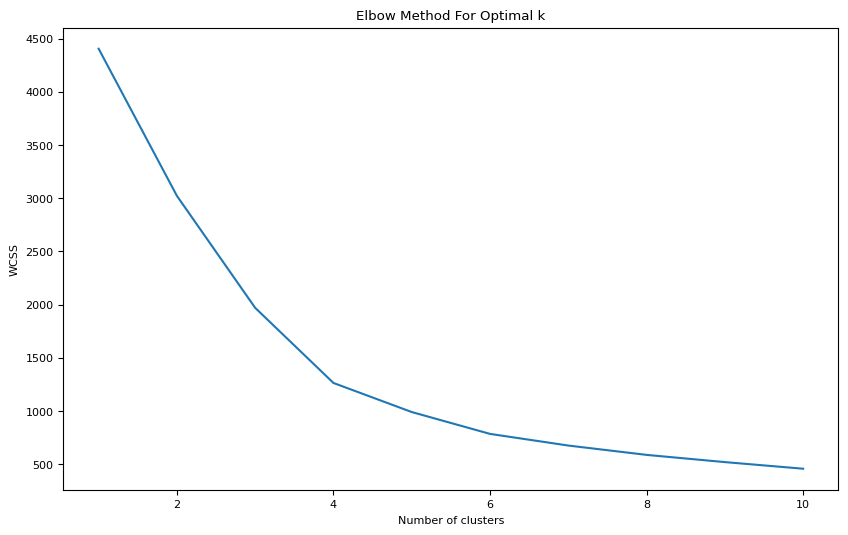

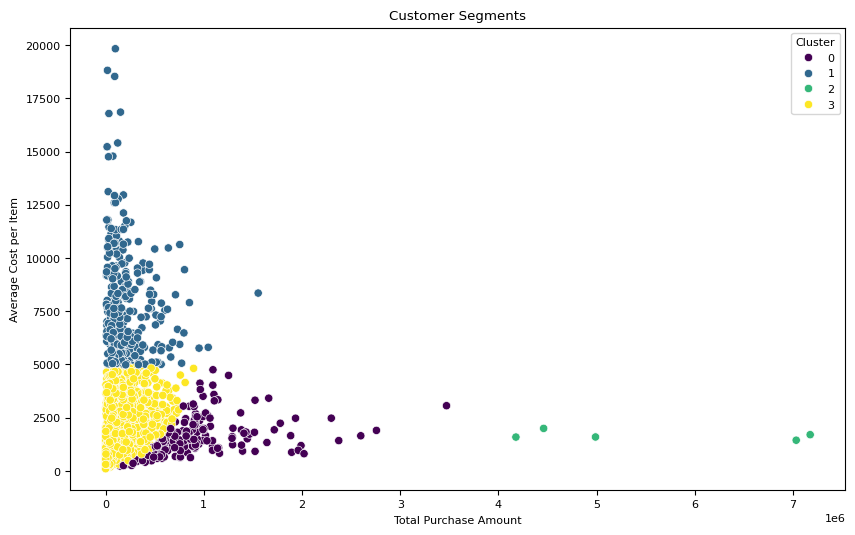

Cluster 0:
Average Total Purchase Amount: 927153.1831646344
Average Cost per Item: 1597.0273182724932

Cluster 1:
Average Total Purchase Amount: 203356.52368976898
Average Cost per Item: 7850.957628081927

Cluster 2:
Average Total Purchase Amount: 5567194.5098
Average Cost per Item: 1666.6875376888438

Cluster 3:
Average Total Purchase Amount: 175540.32402710844
Average Cost per Item: 2076.7490471314745



In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features2 = customer_analysis[['총구매금액', '객단가','총구매수량']].copy()

# Standardize the features
scaler = StandardScaler()
features_scaled2 = scaler.fit_transform(features2)

# Determine the optimal number of clusters using the elbow method
wcss2 = [] # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_scaled2)
    wcss2.append(kmeans.inertia_)  # 여기를 수정합니다.

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# 최적의 군집 개수를 사용하여 K-means 군집화 실행
optimal_clusters = 4 # Elbow Method로 결정한 최적 군집 개수
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_analysis2=customer_analysis.copy()
customer_analysis2['군집'] = kmeans.fit_predict(features_scaled2)

# 군집 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='총구매금액', y='객단가', hue='군집', data=customer_analysis2, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Average Cost per Item')
plt.legend(title='Cluster')
plt.show()

# 군집별 통계 분석
for i in range(optimal_clusters):
    cluster = customer_analysis2[customer_analysis2['군집'] == i]
    print(f"Cluster {i}:")
    print(f"Average Total Purchase Amount: {cluster['총구매금액'].mean()}")
    print(f"Average Cost per Item: {cluster['객단가'].mean()}")
    print()


## 최종적으로 선정된 변수 2개 + 4개의 군집 및 특성

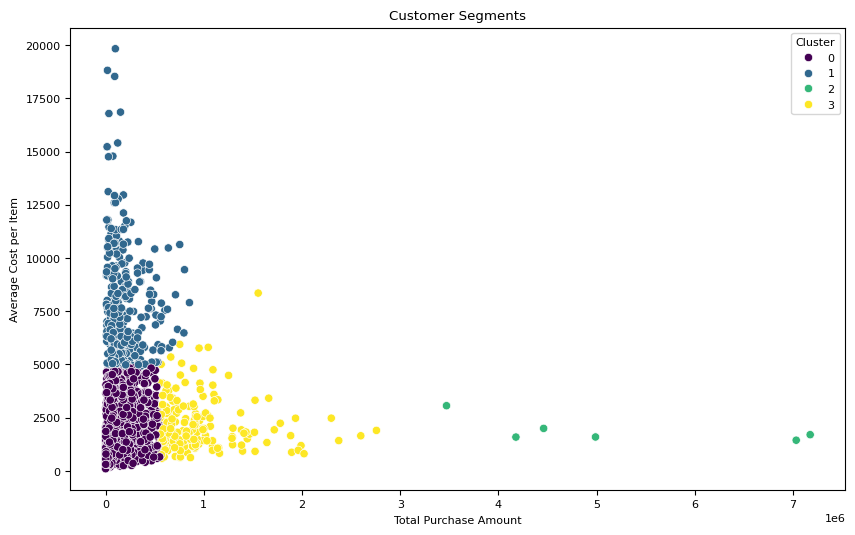

Cluster 0:
Average Total Purchase Amount: 162640.5783492386
Average Cost per Item: 1993.1794259944102
Average Total Purchase count: 113.59796954314722

Cluster 1:
Average Total Purchase Amount: 187432.8364006734
Average Cost per Item: 7887.119218378878
Average Total Purchase count: 26.535353535353536

Cluster 2:
Average Total Purchase Amount: 5217933.751666666
Average Cost per Item: 1899.5903003835392
Average Total Purchase count: 3033.0

Cluster 3:
Average Total Purchase Amount: 939823.107788889
Average Cost per Item: 2224.302477064355
Average Total Purchase count: 555.8888888888889



In [ ]:
import seaborn as sns
# 최적의 군집 개수를 사용하여 K-means 군집화 실행
optimal_clusters = 4 # Elbow Method로 결정한 최적 군집 개수
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
customer_analysis['군집'] = kmeans.fit_predict(features_scaled)

# 군집 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='총구매금액', y='객단가', hue='군집', data=customer_analysis, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Total Purchase Amount')
plt.ylabel('Average Cost per Item')
plt.legend(title='Cluster')
plt.show()

# 군집별 통계 분석
for i in range(optimal_clusters):
    cluster = customer_analysis[customer_analysis['군집'] == i]
    print(f"Cluster {i}:")
    print(f"Average Total Purchase Amount: {cluster['총구매금액'].mean()}")
    print(f"Average Cost per Item: {cluster['객단가'].mean()}")
    print(f"Average Total Purchase count: {cluster['총구매수량'].mean()}")
    print()


## 제품 카테고리화 진행
- 계층적 군집분석 결과와 비계층적 군집분석 서로 똑같은 결과 확인
- 비슷한 그룹은 모아지고, 서로 상이한 제품은 서로 잘분리됨을 시각화로 확인가능
- 3개로 축소


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

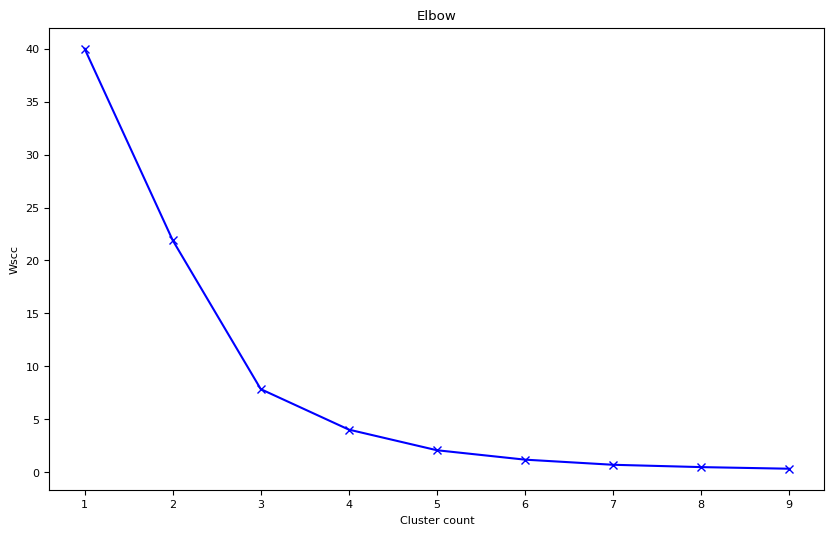

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


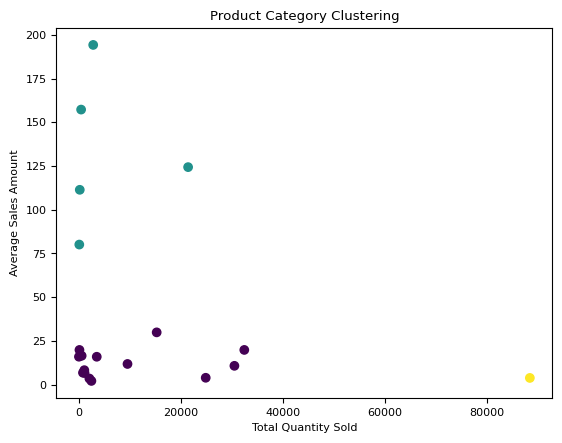

In [4]:
onlinesales_info_clustered = pd.merge(onlinesales_info, customer_analysis[['고객ID', '군집']], on='고객ID', how='left')
# Assuming onlinesales_info is already loaded and contains columns for '제품카테고리', '수량', and '평균금액'
# Aggregate data by product category
onlinesales_info_with_discount=onlinesales_info_clustered.copy()
category_sales = onlinesales_info_with_discount.groupby('제품카테고리').agg(Total_Quantity=('수량', 'sum'),
                                                      Average_Amount=('평균금액', 'mean'),
                                                        total_Amount=('총금액', 'sum'),
                                                        fee=('배송료','mean'),
                                                        sale=('할인율','mean')).reset_index()
from sklearn.preprocessing import StandardScaler

# Select features and scale them
features = category_sales[['Total_Quantity', 'Average_Amount']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 데이터 스케일링이 완료된 features_scaled를 사용합니다
distortions = []
K = range(1, 10)  # 클러스터 개수를 1부터 9까지 시도해보겠습니다.
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(features_scaled)
    distortions.append(kmeanModel.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Cluster count')
plt.ylabel('Wscc')
plt.title('Elbow')
plt.show()

# Analyze the clusters
import matplotlib.pyplot as plt


# Apply k-means clustering
# The choice of n_clusters should be based on domain knowledge or using methods like the Elbow method
kmeans = KMeans(n_clusters=3, random_state=42)
category_sales['Cluster'] = kmeans.fit_predict(features_scaled)

plt.scatter(category_sales['Total_Quantity'], category_sales['Average_Amount'], c=category_sales['Cluster'])
plt.xlabel('Total Quantity Sold')
plt.ylabel('Average Sales Amount')
plt.title('Product Category Clustering')
plt.show()

# Define a function to map clusters to their meanings
def map_cluster_to_category(cluster):
    if cluster == 0:
        return 'Low Price'
    elif cluster == 1:
        return 'High Price'
    elif cluster == 2:
        return 'Office Supplies'
    else:
        return 'Unknown'

# Apply the function to the 'Cluster' column
category_sales['Category'] = category_sales['Cluster'].apply(map_cluster_to_category)
new_df=pd.merge(onlinesales_info_with_discount, category_sales[['제품카테고리', 'Category']], on='제품카테고리', how='left')

## 덴드로그램 결과와 k-means 일치


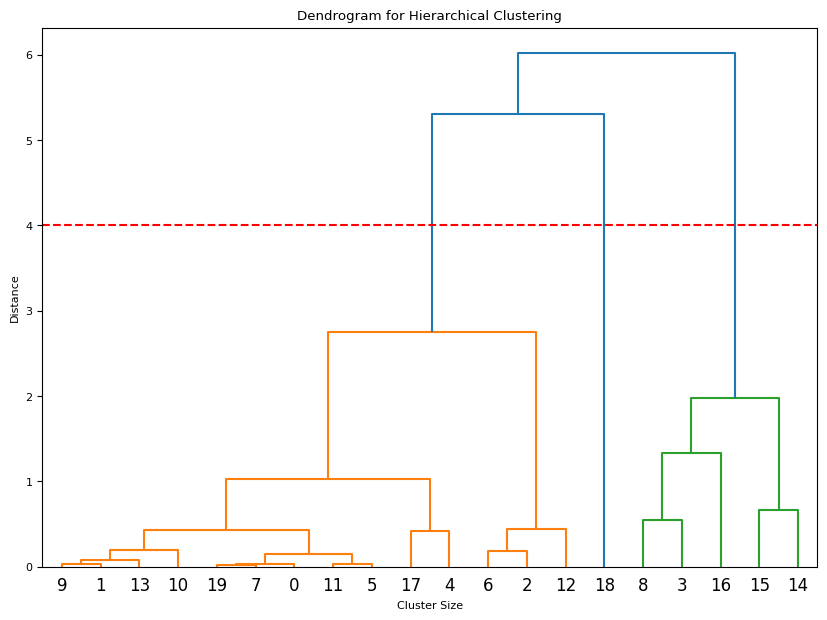

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 계층적 군집 분석을 위해 Ward 방식 사용
linked = linkage(features_scaled, 'ward')

# 덴드로그램 그리기
plt.figure(figsize=(10, 7))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
# 높이 4에서 빨간색 수평선 추가
plt.axhline(y=4, color='r', linestyle='--')
plt.show()

# 특정 거리에서 군집을 나누기
# 예: distance = 10에서 군집화
max_distance = 3
clusters = fcluster(linked, max_distance, criterion='distance')
# 높이 4에서 빨간색 수평선 추가



In [6]:
category_sales

,제품카테고리,Total_Quantity,Average_Amount,total_Amount,fee,sale,Cluster,Category
0,Accessories,1097,8.211068,6.517729e+05,11.911410,20.726496,0,Low Price
1,Android,45,15.903488,6.230263e+04,8.527674,20.465116,0,Low Price
2,Apparel,32438,19.788995,5.603546e+07,9.757500,20.042480,0,Low Price
3,Backpacks,113,80.046404,9.661588e+05,13.066517,0.000000,1,High Price
4,Bags,15273,29.830797,1.434645e+07,13.626488,19.766206,0,Low Price
5,Bottles,2090,3.437201,5.839997e+05,13.078246,19.589552,0,Low Price
6,Drinkware,30501,10.696893,1.906409e+07,14.392242,19.873672,0,Low Price
7,Fun,834,6.743812,7.133035e+05,11.751938,0.000000,0,Low Price
8,Gift Cards,206,111.363270,1.757481e+06,0.000000,16.226415,1,High Price
9,Google,575,16.446190,1.039058e+06,26.726571,0.000000,0,Low Price


# 3. RFM 분석
## 여기서 R,F,M의 정의는 아래와 같다
Recency (R): 고객의 최근 구매 행동을 평가. 코드에서는 각 고객별로 가장 최근 거래 날짜를 찾고, 그 날짜와 데이터셋 내의 최대 날짜 간의 차이(일수)를 계산 이 차이를 기반으로 고객을 여러 구간으로 나누고, 구간에 따라 점수를 부여.(가장 최근에 구매한 고객에게 높은 점수)

Frequency (F): 고객의 구매 빈도를 평가. 여기서는 고객별로 거래된 고유한 날짜의 수를 계산하여, 고객이 얼마나 자주 구매하는지 측정. 단, 구매 빈도가 매우 낮은 고객들이 많기 때문에, 이 코드는 특정 구매 빈도(예: 하루에 1번, 2번 등)에 직접 점수를 할당하는 방식을 사용.

Monetary (M): 고객의 구매 금액을 평가. 각 고객별로 총 평균금액을 계산하고, 이를 기반으로 고객을 여러 구간으로 나누어 점수를 부여.(더 높은 금액을 지출한 고객에게 높은 점수).

In [ ]:
category_sales.groupby('Category').mean()
new_df['거래날짜'] = pd.to_datetime(new_df['거래날짜'])
new_df['거래년월'] = new_df['거래날짜'].dt.to_period('M')


<ipython-input-8-b017e5d5f87c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  category_sales.groupby('Category').mean()


In [ ]:

### R 구하기
Recency = new_df.groupby('고객ID')['거래날짜'].max().reset_index()
Recency
max_date = Recency['거래날짜'].max()
Recency['diff_date']=(max_date - Recency['거래날짜']).dt.days
# pd.qcut 활용하여 가장 낮은 구간에 5점 , 가장 높은 구간에 1점 부여

# 데이터를 구간으로 나누기
Recency['R'] = pd.qcut(Recency['diff_date'], q=5, labels=False, duplicates='drop')

# 각 구간에 점수 부여
Recency['R'] = Recency['R'].max() - Recency['R'] + 1
### F 구하기
# Recency , 고객ID 활용하여 F 구하기
# 같은 ID 중복 날짜 -> 하루에 여러번 구매
Frequency = new_df.groupby('고객ID')['거래날짜'].nunique().reset_index()
Frequency['거래날짜'].value_counts()
# 하루에 1번 구매한 사람이 가장 많음
# 1회 , 2회만 구매한 고객이 너무 많아서 pd.qcut 적용 불가능
def parse_values(x):
    switch = {
        1 : 1 ,
        2 : 2 ,
        3 : 3 ,
        4 : 4
    }
    return switch.get(x,5)

Frequency['F']=Frequency['거래날짜'].apply(parse_values)
### M 구하기
Monetary = new_df.groupby('고객ID')['평균금액'].sum().reset_index()
Monetary
# qcut 활용하여 M 점수 만들기

# 데이터를 구간으로 나누기
Monetary['M'] = pd.qcut(Monetary['평균금액'], q=5, labels=[1,2,3,4,5])
rm=pd.merge(Monetary,Recency,on='고객ID',how='outer')
rfm = pd.merge(rm,Frequency,on='고객ID',how='outer')
rfm.rename(columns={'평균금액':'Monetary','거래날짜_x':'Recency','거래날짜_y':'Frequency'},inplace=True)
# rfm_score을 합치기 위해 string으로 형 변환
rfm['R'] = rfm['R'].astype(str)
rfm['F'] = rfm['F'].astype(str)
rfm['M'] = rfm['M'].astype(str)
# rfm_score 합치기
rfm['rfm_score'] = rfm['R'] + rfm['F'] + rfm['M']
segments = {
    r'111|112|121|131|141|151' : 'no.11',
    r'332|322|233|232|223|222|132|123|122|212|211' : 'no.10',
    r'155|154|144|214|215|115|114|113' : 'no.9',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124' : 'no.8',
    r'331|321|312|221|213|231|241|251' : 'no.7',
    r'535|534|443|434|343|334|325|324' : 'no.6 ',
    r'525|524|523|515|514|513|425|424|413|414|415|315|314|313' : 'no.5 ',
    r'522|521|512|511|422|421|412|411|311' : 'no.4 ',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323' : 'no.3 ',
    r'543|444|435|355|354|345|344|335' : 'no.2 ',
    r'555|554|544|545|454|455|445' : 'no.1 '
}

rfm['segment'] = rfm['rfm_score'].replace(segments, regex=True)
# 기존데이터와 rfm 데이터 합쳐서 최종 프레임 도출
new_df2=pd.merge(new_df,rfm,on='고객ID',how='outer')

# 4.  군집분석 + RFM 분석

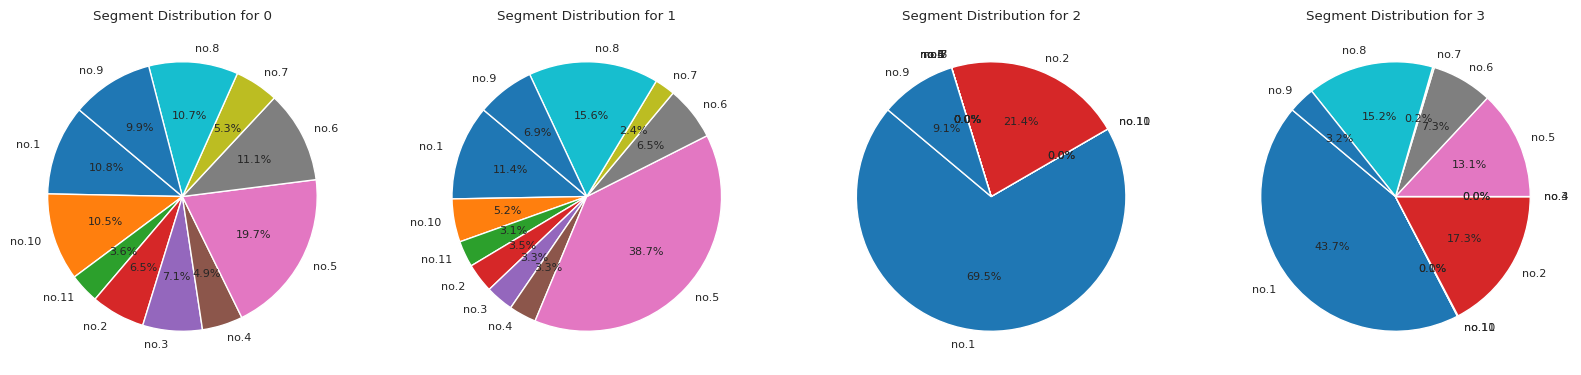

In [ ]:

segment_distribution = new_df2.groupby('군집')['segment'].value_counts().unstack().fillna(0)

# 파이 차트로 각 군집별 segment 분포를 시각화
fig, axs = plt.subplots(1, len(segment_distribution.index), figsize=(20, 10))

for (i, cluster) in enumerate(segment_distribution.index):
    axs[i].pie(segment_distribution.loc[cluster], labels=segment_distribution.columns, autopct='%1.1f%%', startangle=140)
    axs[i].set_title(f'Segment Distribution for {cluster}')

plt.show()


## 군집 내 개수 카운트

In [ ]:
new_df2.groupby('군집')['segment'].value_counts()

군집  segment
0   no.5       4884
    no.6       2737
    no.1       2673
    no.8       2650
    no.10      2597
    no.9       2440
    no.3       1767
    no.2       1600
    no.7       1300
    no.4       1207
    no.11       888
1   no.5       2096
    no.8        844
    no.1        617
    no.9        375
    no.6        351
    no.10       280
    no.2        190
    no.3        181
    no.4        178
    no.11       170
    no.7        132
2   no.1       2257
    no.2        695
    no.9        297
3   no.1       8534
    no.2       3378
    no.8       2958
    no.5       2549
    no.6       1424
    no.9        623
    no.7         37
    no.11        15
Name: segment, dtype: int64

## RFM의 고객을 순서척도로 변경하여, 시각적으로도 그리고 처리하기에도 편하게 변경

In [ ]:

### R 구하기
Recency = new_df.groupby('고객ID')['거래날짜'].max().reset_index()
Recency
max_date = Recency['거래날짜'].max()
Recency['diff_date']=(max_date - Recency['거래날짜']).dt.days
# pd.qcut 활용하여 가장 낮은 구간에 5점 , 가장 높은 구간에 1점 부여

# 데이터를 구간으로 나누기
Recency['R'] = pd.qcut(Recency['diff_date'], q=5, labels=False, duplicates='drop')

# 각 구간에 점수 부여
Recency['R'] = Recency['R'].max() - Recency['R'] + 1
### F 구하기
# Recency , 고객ID 활용하여 F 구하기
# 같은 ID 중복 날짜 -> 하루에 여러번 구매
Frequency = new_df.groupby('고객ID')['거래날짜'].nunique().reset_index()
Frequency['거래날짜'].value_counts()
# 하루에 1번 구매한 사람이 가장 많음
# 1회 , 2회만 구매한 고객이 너무 많아서 pd.qcut 적용 불가능
def parse_values(x):
    switch = {
        1 : 1 ,
        2 : 2 ,
        3 : 3 ,
        4 : 4
    }
    return switch.get(x,5)

Frequency['F']=Frequency['거래날짜'].apply(parse_values)
### M 구하기
Monetary = new_df.groupby('고객ID')['평균금액'].sum().reset_index()
Monetary
# qcut 활용하여 M 점수 만들기

# 데이터를 구간으로 나누기
Monetary['M'] = pd.qcut(Monetary['평균금액'], q=5, labels=[1,2,3,4,5])
rm=pd.merge(Monetary,Recency,on='고객ID',how='outer')
rfm = pd.merge(rm,Frequency,on='고객ID',how='outer')
rfm.rename(columns={'평균금액':'Monetary','거래날짜_x':'Recency','거래날짜_y':'Frequency'},inplace=True)
# rfm_score을 합치기 위해 string으로 형 변환
rfm['R'] = rfm['R'].astype(str)
rfm['F'] = rfm['F'].astype(str)
rfm['M'] = rfm['M'].astype(str)
# rfm_score 합치기
rfm['rfm_score'] = rfm['R'] + rfm['F'] + rfm['M']
segments = {
    r'111|112|121|131|141|151' : 'no.11',
    r'332|322|233|232|223|222|132|123|122|212|211' : 'no.10',
    r'155|154|144|214|215|115|114|113' : 'no.9',
    r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124' : 'no.8',
    r'331|321|312|221|213|231|241|251' : 'no.7',
    r'535|534|443|434|343|334|325|324' : 'no.6 ',
    r'525|524|523|515|514|513|425|424|413|414|415|315|314|313' : 'no.5 ',
    r'522|521|512|511|422|421|412|411|311' : 'no.4 ',
    r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323' : 'no.1~no.3 ',
    r'543|444|435|355|354|345|344|335' : 'no.1~no.3 ',
    r'555|554|544|545|454|455|445' : 'no.1~no.3 '
}

rfm['segment'] = rfm['rfm_score'].replace(segments, regex=True)
# 기존데이터와 rfm 데이터 합쳐서 최종 프레임 도출
new_df3=pd.merge(new_df,rfm,on='고객ID',how='outer')

In [ ]:
new_df3.groupby('군집')['segment'].value_counts()

군집  segment   
0   no.1~no.3      6040
    no.5           4884
    no.6           2737
    no.8           2650
    no.10          2597
    no.9           2440
    no.7           1300
    no.4           1207
    no.11           888
1   no.5           2096
    no.1~no.3       988
    no.8            844
    no.9            375
    no.6            351
    no.10           280
    no.4            178
    no.11           170
    no.7            132
2   no.1~no.3      2952
    no.9            297
3   no.1~no.3     11912
    no.8           2958
    no.5           2549
    no.6           1424
    no.9            623
    no.7             37
    no.11            15
Name: segment, dtype: int64

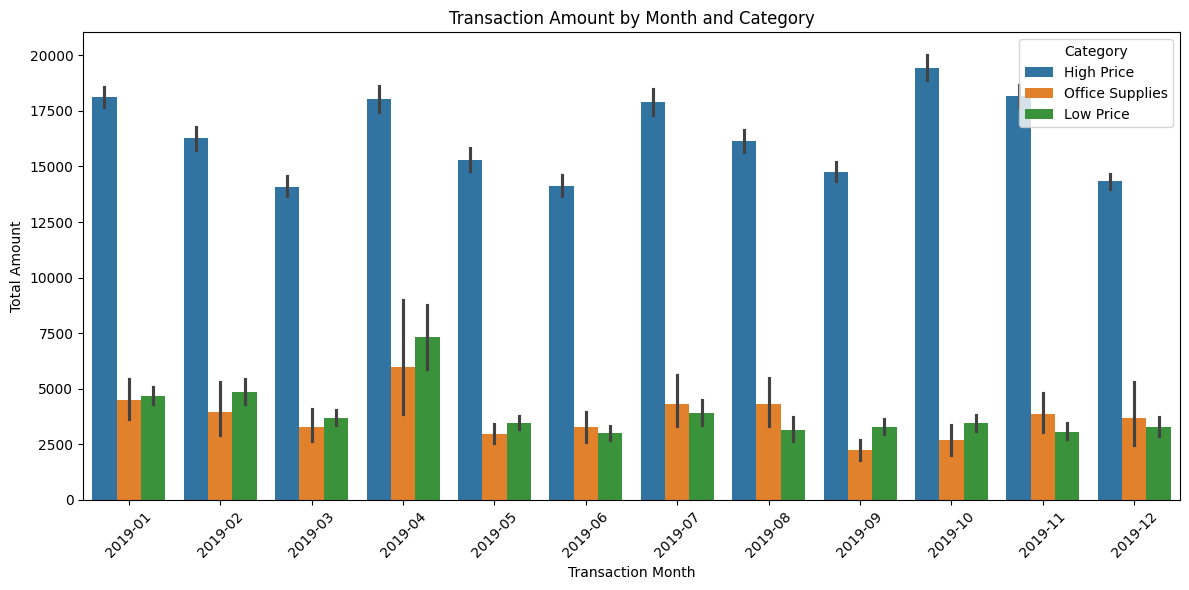

In [ ]:
new_df
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='거래년월', y='총금액', hue='Category', data=new_df)
plt.title('Transaction Amount by Month and Category')
plt.xlabel('Transaction Month')
plt.ylabel('Total Amount')
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()

In [ ]:
# Calculating the total amount by category
total_amount_by_category = new_df.groupby('Category')['총금액'].sum()

# Calculating the total amount of all transactions
total_amount = new_df['총금액'].sum()

# Calculating the percentage of total amount by category
percentage_by_category = (total_amount_by_category / total_amount) * 100

# Displaying the percentage of total amount by category
percentage_by_category


Category
High Price         66.450657
Low Price          27.627882
Office Supplies     5.921461
Name: 총금액, dtype: float64

# 5. 결론
- 월별 군집별 총 판매량 확인과 더불어 쿠폰 사용 비율 확인
- 배송비는 제품에 따라 구분 되는점 확인


<ipython-input-91-50b5090a1386>:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  monthly_coupon_status_ratio_by_cluster = monthly_coupon_status_counts_by_cluster.groupby(level=0).apply(


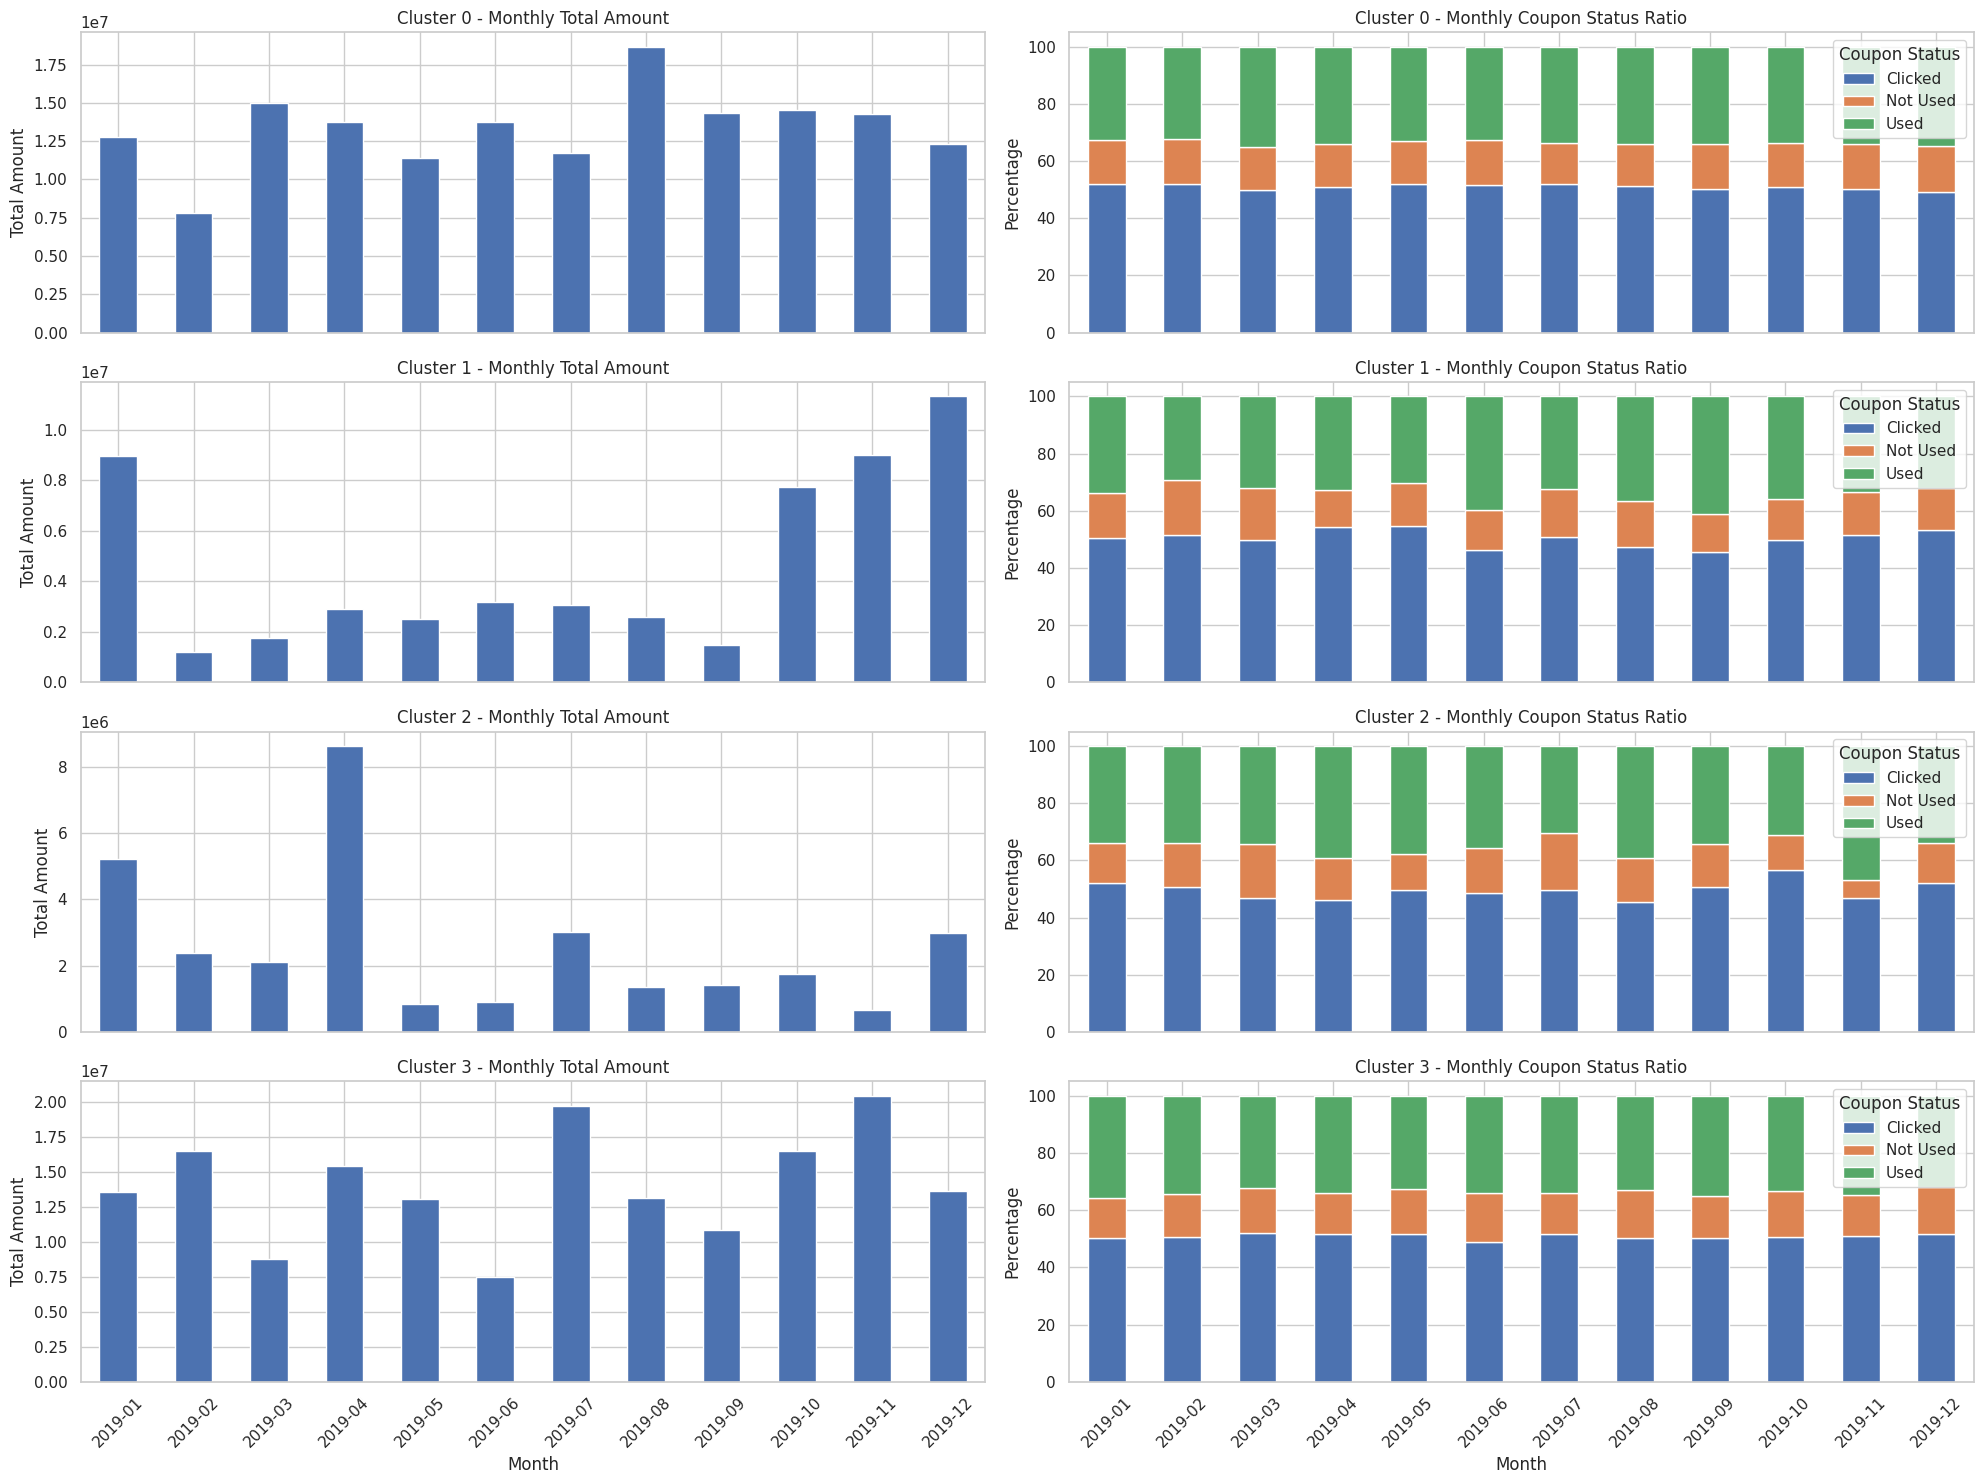

In [ ]:
# For a comprehensive comparison, let's calculate the monthly total amount and coupon status ratio for all clusters

# Monthly total amount by cluster
monthly_total_amount_by_cluster = new_df.groupby(['군집', '거래년월'])['총금액'].sum().unstack(fill_value=0)

# Monthly coupon status count by cluster
monthly_coupon_status_counts_by_cluster = new_df.groupby(['군집', '거래년월', '쿠폰상태']).size().unstack(level=-1, fill_value=0)

# Monthly coupon status ratio by cluster
monthly_coupon_status_ratio_by_cluster = monthly_coupon_status_counts_by_cluster.groupby(level=0).apply(
    lambda x: x.div(x.sum(axis=1), axis=0) * 100
)

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(20, 15), sharex='col')

for cluster in range(4):
    # Monthly total amount for each cluster
    if cluster in monthly_total_amount_by_cluster.index:
        monthly_total_amount_by_cluster.loc[cluster].plot(kind='bar', ax=axes[cluster, 0])
        axes[cluster, 0].set_title(f'Cluster {cluster} - Monthly Total Amount')
        axes[cluster, 0].set_ylabel('Total Amount')
    else:
        axes[cluster, 0].text(0.5, 0.5, f'No data for Cluster {cluster}', horizontalalignment='center', verticalalignment='center')

    # Monthly coupon status ratio for each cluster
    if cluster in monthly_coupon_status_ratio_by_cluster.index:
        monthly_coupon_status_ratio_by_cluster.loc[cluster].plot(kind='bar', stacked=True, ax=axes[cluster, 1])
        axes[cluster, 1].set_title(f'Cluster {cluster} - Monthly Coupon Status Ratio')
        axes[cluster, 1].set_ylabel('Percentage')
        axes[cluster, 1].legend(title='Coupon Status')
    else:
        axes[cluster, 1].text(0.5, 0.5, f'No data for Cluster {cluster}', horizontalalignment='center', verticalalignment='center')

for ax in axes[:, 0]:
    ax.set_xlabel('Month')
    ax.tick_params(axis='x', rotation=45)

for ax in axes[:, 1]:
    ax.set_xlabel('Month')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 월별 제품별 총금액 계산
monthly_product_sales = new_df.groupby(['거래년월', 'Category'])['총금액'].sum().unstack().fillna(0)

# 시각화
plt.figure(figsize=(15, 8))

# 월별 제품별 총금액 그래프
monthly_product_sales.plot(kind='bar', stacked=True)
plt.title('Monthly Total Amount by Product Category')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#nest의 비율이 굉장히 높음. 이것을 중심으로 풀어나가는 것이 좋을듯함 insight1
# 제품 판매 추이 확인해야겠는데?

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,GST,월,쿠폰코드,할인율,총금액,군집,평균구매금액,거래년월,Category
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,0.10,Jan,ELEC10,10.0,15223.790,2,153.71,2019-01,High Price
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,0.10,Jan,ELEC10,10.0,15223.790,0,153.71,2019-01,High Price
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,0.10,Jan,OFF10,10.0,209.450,0,2.05,2019-01,Office Supplies
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,0.18,Jan,SALE10,10.0,9314.930,2,87.65,2019-01,Low Price
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,0.18,Jan,AIO10,10.0,1758.800,2,16.50,2019-01,Low Price
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,0.10,Dec,ELEC30,30.0,9346.600,1,121.30,2019-12,High Price
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,0.18,Dec,SALE30,30.0,4047.292,1,48.92,2019-12,Low Price
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,0.10,Dec,ELEC30,30.0,11701.260,1,151.88,2019-12,High Price
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,0.10,Dec,ELEC30,30.0,31006.700,1,402.60,2019-12,High Price


<Figure size 1500x800 with 0 Axes>

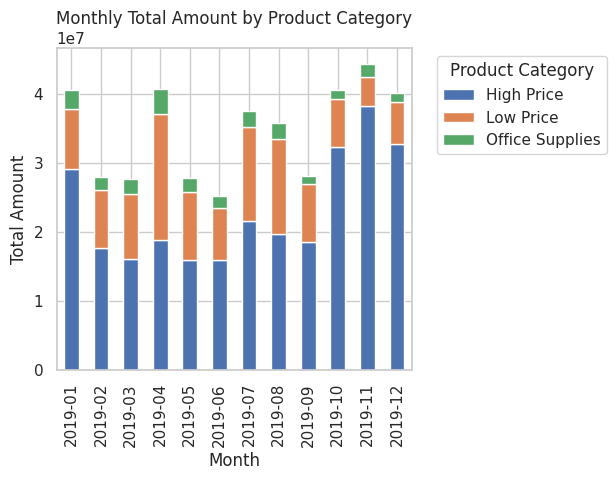

In [ ]:
# 월별 제품별 총금액 계산
monthly_product_sales = new_df.groupby(['거래년월', 'Category'])['총금액'].sum().unstack().fillna(0)

# 시각화
plt.figure(figsize=(15, 8))

# 월별 제품별 총금액 그래프
monthly_product_sales.plot(kind='bar', stacked=True)
plt.title('Monthly Total Amount by Product Category')
plt.xlabel('Month')
plt.ylabel('Total Amount')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#nest의 비율이 굉장히 높음. 이것을 중심으로 풀어나가는 것이 좋을듯함 insight1
# 제품 판매 추이 확인해야겠는데?

In [ ]:
new_df.groupby('Category')['배송료'].mean()

Category
High Price          7.140482
Low Price          11.418877
Office Supplies    15.115601
Name: 배송료, dtype: float64

In [ ]:
pd.merge(new_df, customer_info[['고객ID', '고객지역']], on='고객ID', how='left').groupby('고객지역')['배송료'].mean()

고객지역
California       10.718275
Chicago          10.507412
New Jersey        9.496165
New York         10.698711
Washington DC    10.344374
Name: 배송료, dtype: float64

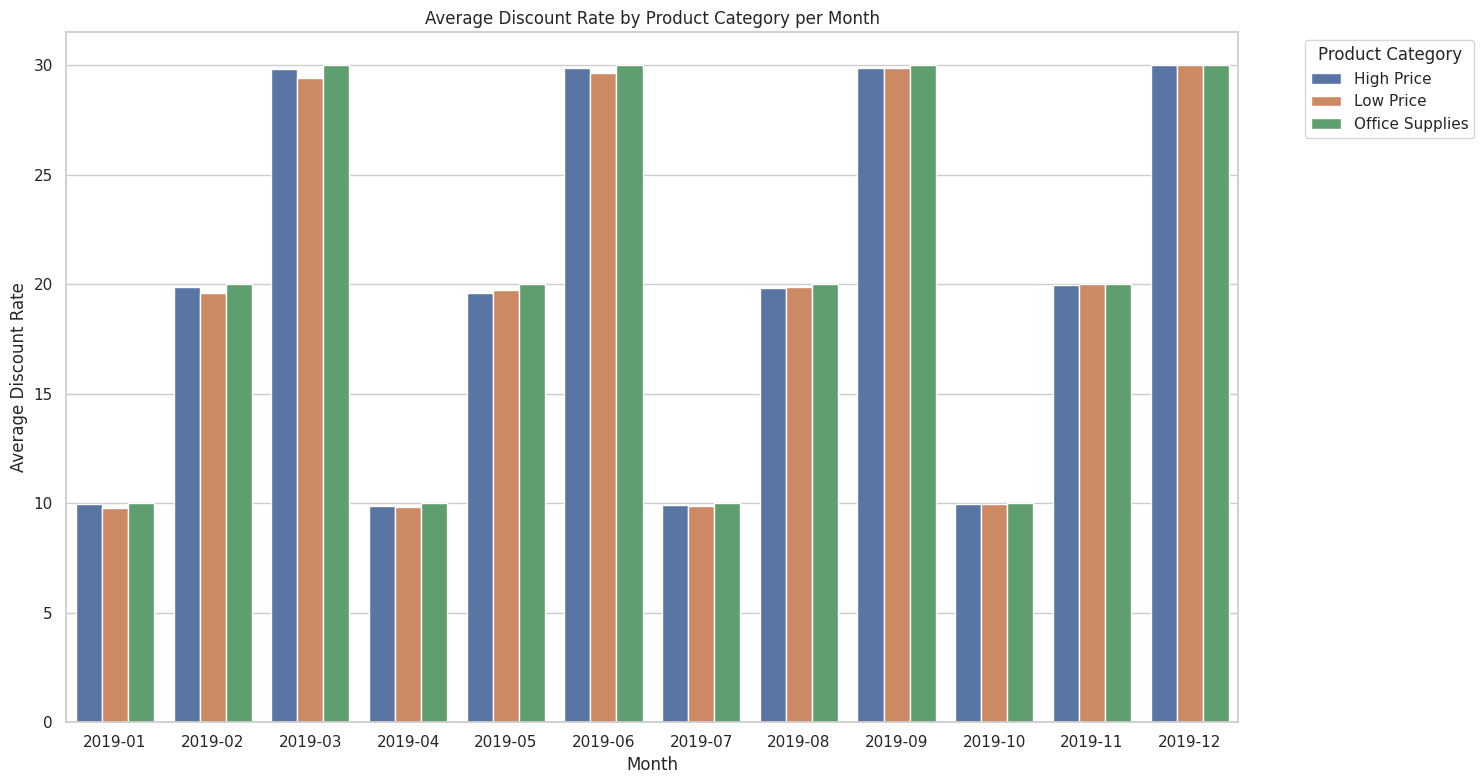

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 프레임 new_df를 가정하여, 거래년월, Category별 할인률 평균 계산
monthly_discount_avg = new_df.groupby(['거래년월', 'Category'])['할인율'].mean().reset_index()

# 시각화 설정
plt.figure(figsize=(15, 8))

# seaborn을 사용한 시각화
sns.barplot(x='거래년월', y='할인율', hue='Category', data=monthly_discount_avg)

plt.title('Average Discount Rate by Product Category per Month')
plt.xlabel('Month')
plt.ylabel('Average Discount Rate')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
